## Task1: Animate bivariate normal distribution. 

In [1]:
import jax
from jax import numpy as jnp
from jax.scipy.stats import multivariate_normal
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import mpl_toolkits.mplot3d.art3d as art3d
import numpy as np
import seaborn as sns

Defining gaussian distribution

In [2]:
mean = jnp.array([0,0])
covariance = jnp.array([[1,0.6],[0.6,2]])
X = jnp.arange(-5.0,5.0,0.1)
Y = jnp.arange(-5.0,5.0,0.1) 

In [3]:
X_pdf =  multivariate_normal.pdf(X,mean[0],jnp.sqrt(covariance[0,0]))
Y_pdf =  multivariate_normal.pdf(Y,mean[1],jnp.sqrt(covariance[1,1]))

Creating samples

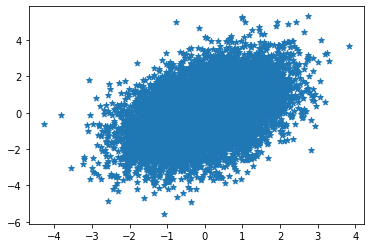

In [4]:
sample = jax.random.multivariate_normal(jax.random.PRNGKey(42),mean,covariance,shape = [10000,])
plt.scatter(sample[:,0],sample[:,1],marker = '*')

 3 sigma ellipse using eigenvalues and eigenvactors

In [5]:
def sigma_ellipse(sample):
  fig, ax = plt.subplots(1,1)

  sc = ax.scatter(sample[:,0],sample[:,1],marker = '*')

  eigenvalues,eigenvectors = jnp.linalg.eig(covariance)
  eigenvalues = jnp.real(eigenvalues)
  eigenvectors = jnp.real(eigenvectors)

  largest_index= jnp.argmax(eigenvalues)
  largest_eigenvector = eigenvectors[:,largest_index]
  largest_eigenvalue = max(eigenvalues)

  smallest_index = jnp.argmin(eigenvalues)
  smallest_eigenvector =  eigenvectors[:,smallest_index]
  smallest_eigenvalue =  min(eigenvalues)

  angle = jnp.arctan2(largest_eigenvector[1], largest_eigenvector[0])

  if(angle < 0):
    angle = angle + 2*jnp.pi

  theta_grid = jnp.linspace(0,2*jnp.pi)
  phi = angle
  ellipse_radius_a= 3*jnp.sqrt(covariance[0,0])*jnp.sqrt(largest_eigenvalue)
  ellipse_radius_b= 3*jnp.sqrt(covariance[1,1])*jnp.sqrt(smallest_eigenvalue)

  ellipse_x_r  = ellipse_radius_a*jnp.cos( theta_grid)
  ellipse_y_r  = ellipse_radius_b*jnp.sin( theta_grid)

  R = jnp.array([[jnp.cos(phi), jnp.sin(phi)],[ -jnp.sin(phi), jnp.cos(phi)]])

  radius_vector = jnp.array([ellipse_x_r, ellipse_y_r])
  radius_ellipse = jnp.dot(np.transpose(radius_vector),R)

  ax.plot(radius_ellipse[:,0],radius_ellipse[:,1],c = 'r')

  return radius_ellipse

In [6]:
def mvn_plot(sample,radius_ellipse,X,Y,X_pdf,Y_pdf):
  fig = plt.figure()
  ax = fig.add_subplot(projection='3d')

  ax.set_xlabel("x")

  ax.set_ylabel("y")

  ax.set_zlabel("z")

  ax.scatter3D(sample[:,0],sample[:,1],zs=0,zdir='z',marker = '*')

  ax.plot(radius_ellipse[:,1],radius_ellipse[:,0],c = 'r')

  hist_x,edges_x =  jnp.histogram(sample[:,0],20,density = True)
  hist_y,edges_y = jnp.histogram(sample[:,1],20,density = True)

  ax.plot(X,X_pdf,zs=-7, zdir='y')
  ax.bar(edges_x[:20,],hist_x,zs=-7,  zdir='y', color = 'black' ,fill = False,alpha = 0.7)

  ax.plot(Y,Y_pdf, zs=-5, zdir='x')
  ax.bar(edges_y[:20,],hist_y,zs=-5,  zdir='x', color = 'black',fill = False,alpha = 0.7)
  ax.view_init(elev=45., azim=55)

  ax.set_title("Multivariate Normal Distribution")
  ax.set_xlabel("X")
  ax.set_ylabel("Y")
  ax.set_zlabel("p(Y)")
  ax.set_xlim(-5,5)
  ax.set_ylim(-7,6)
  sns.despine()
  plt.show()
  return fig, ax
  # fig.savefig("Multivariate Normal Distribution")

Creating interact by varying the random state, number of samples, mean and covariance

In [7]:
from ipywidgets import interact

@interact(random_state=(1, 10),N=(1000,10000,200),k=(0,1,0.2),u=(0,2,0.2))
def generate_random(random_state, N,k,u):
    key = jax.random.PRNGKey(random_state)
    mean=jnp.array([k,u])
    covariance=jnp.array([[1,k],[k,2]])
    X = jnp.arange(-5.0,5.0,0.1)
    Y = jnp.arange(-5.0,5.0,0.1) 
    X_pdf =  multivariate_normal.pdf(X,mean[0],jnp.sqrt(covariance[0,0]))
    Y_pdf =  multivariate_normal.pdf(Y,mean[1],jnp.sqrt(covariance[1,1]))
    sample = jax.random.multivariate_normal(key,mean,covariance,shape = [N,])
    radius_ellipse = sigma_ellipse(sample)
    fig, ax = mvn_plot(sample,radius_ellipse,X,Y,X_pdf,Y_pdf)
    sns.despine()
    ax.set_yticks(jnp.linspace(0, 1, 11))

interactive(children=(IntSlider(value=5, description='random_state', max=10, min=1), IntSlider(value=5400, des…

sns plot

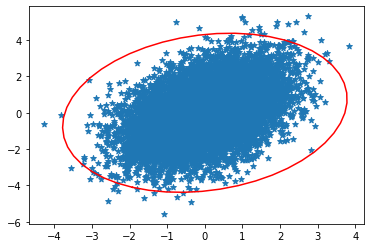

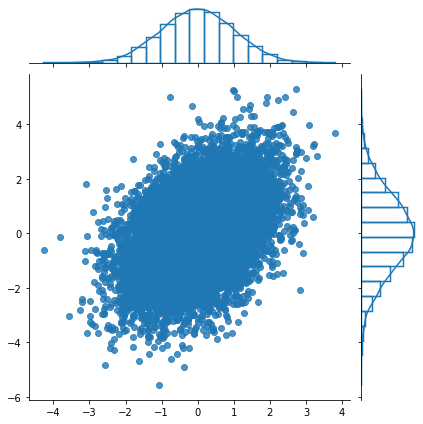

In [8]:
radius_ellipse = sigma_ellipse(sample)
ellipse = Ellipse((0, 0), width=radius_ellipse[:,0], height=radius_ellipse[:,1],
                  facecolor = 'none',edgecolor = 'red')

a = sns.jointplot(x = sample[:,0], y = sample[:,1],
              kind = "reg", data = sample,fit_reg = False,marginal_kws=dict(bins=20, fill=False))

plt.show()